# Automated Multiple Reaction Monitoring (MRM)-profiling and Ozone Electrospray Ionizaton (OzESI)-MRM Informatics Platform for High-throughput Lipidomics


In this jupyter notebook you will automate the data analysis of the lipidome. This is a challenging problem to perform manually due to the diverse nature of lipids and the many potential isomers. In this notebook you will analyze mzML files containing data from lipid MRMs, with ozone off and ozone on. The goal is to identify possible double-bond locations in a lipid, in this case a TAG (triacylglycerols).

In [44]:
from IPython.display import Image

![title](Figures/agilent_lcms.png)

The examples shown here were run on an Agilent 6495C Triple Quadrupole LC/MS (example shown above) that has been connected to an ozone line (not shown in picture) for ozoneolysis of lipids.

![title](Figures/TAG_example.png)
Here is an example of a TAG. Notice how many possibilities there are for locations of one double-bond there could be and how convoluted the analysis can become! This image is obtained from LipidMaps.org

Import all necessary libraries

In [1]:
#Import all the necessary libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import re
import plotly.express as px

No module named 'ms_deisotope._c.averagine' averagine
No module named 'ms_deisotope._c.scoring'
No module named 'ms_deisotope._c.deconvoluter_base'
No module named 'ms_deisotope._c.deconvoluter_base'
No module named 'ms_deisotope._c.deconvoluter_base'


MAKE CLASSES FOR EACH LIPID

In [ ]:
lipid_types = ["CE","TAG","CER","FFA","PC","PE","PG","PI","SM","AC"]
database_path = "lipid_database/Lipid_Database.xlsx"

#loop through all sheets in SUPPLE_2.XLS and make a df of Compound Name, Parent Ion, and Product Ion
mrm_list_new = pd.read_excel('lipid_database/Lipid_Database.xlsx', sheet_name = None)
mrm_list_new = pd.concat(mrm_list_new, ignore_index=True)
mrm_list_offical = mrm_list_new[['Compound Name', 'Parent Ion', 'Product Ion', 'Class']]
#Add underscore to middle of columns names
mrm_list_offical.columns = mrm_list_offical.columns.str.replace(' ', '_')
#round Parent Ion and Product Ion to 1 decimal place
mrm_list_offical['Parent_Ion'] = np.floor(mrm_list_offical['Parent_Ion'].round(1))
mrm_list_offical['Product_Ion'] = np.floor(mrm_list_offical['Product_Ion'].round(1))
#create transition column by combining Parent Ion and Product Ion with arrow between numbers
mrm_list_offical['Transition'] = mrm_list_offical['Parent_Ion'].astype(str) + ' -> ' + mrm_list_offical['Product_Ion'].astype(str)
#change column compound name to lipid
mrm_list_offical = mrm_list_offical.rename(columns={'Compound_Name': 'Lipid'})
#make a column called Class match lipid column to lipid types



pd.set_option('display.max_rows', None)
print(mrm_list_offical.head(None))


In [2]:

def read_mrm_list(filename):
    mrm_list_new = pd.read_excel(filename, sheet_name=None)
    mrm_list_new = pd.concat(mrm_list_new, ignore_index=True)
    mrm_list_offical = mrm_list_new[['Compound Name', 'Parent Ion', 'Product Ion', 'Class']]
    # Add underscore to middle of columns names
    mrm_list_offical.columns = mrm_list_offical.columns.str.replace(' ', '_')
    # Round Parent Ion and Product Ion to 1 decimal place
    mrm_list_offical['Parent_Ion'] = np.floor(mrm_list_offical['Parent_Ion'].round(1))
    mrm_list_offical['Product_Ion'] = np.floor(mrm_list_offical['Product_Ion'].round(1))
    # Create transition column by combining Parent Ion and Product Ion with arrow between numbers
    mrm_list_offical['Transition'] = mrm_list_offical['Parent_Ion'].astype(str) + ' -> ' + mrm_list_offical['Product_Ion'].astype(str)
    # Change column compound name to lipid
    mrm_list_offical = mrm_list_offical.rename(columns={'Compound_Name': 'Lipid'})
    # Make a column called Class match lipid column to lipid types
    return mrm_list_offical

mrm_database = read_mrm_list('lipid_database/Lipid_Database.xlsx')
mrm_database.tail()

/tmp/ipykernel_7529/2289239920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrm_list_offical['Parent_Ion'] = np.floor(mrm_list_offical['Parent_Ion'].round(1))
/tmp/ipykernel_7529/2289239920.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrm_list_offical['Product_Ion'] = np.floor(mrm_list_offical['Product_Ion'].round(1))
/tmp/ipykernel_7529/2289239920.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Lipid  Parent_Ion  Product_Ion  \
3264  STD_15:0-18:1(d7) PI (NH4 Salt)       847.0        570.0   
3265   STD_15:0-18:1(d7) PS (Na Salt)       755.0        570.0   
3266       STD_15:0-18:1(d7)-15:0 TAG       829.0        570.0   
3267          STD_18:1(d7) Chol Ester       675.0        369.0   
3268            STD_d18:1-18:1(d9) SM       738.0        184.0   

                                Class      Transition  
3264  STD_15:0-18:1(d7) PI (NH4 Salt)  847.0 -> 570.0  
3265   STD_15:0-18:1(d7) PS (Na Salt)  755.0 -> 570.0  
3266       STD_15:0-18:1(d7)-15:0 TAG  829.0 -> 570.0  
3267          STD_18:1(d7) Chol Ester  675.0 -> 369.0  
3268            STD_d18:1-18:1(d9) SM  738.0 -> 184.0

In [3]:
list_of_lipid_classes = mrm_database['Class'].unique()
print(list_of_lipid_classes)

['PC' 'PE' 'SM' 'Cer' 'CAR' 'TAG' 'DAG' 'PS' 'PI' 'PG' 'CE' 'FA'
 'STD 15:0-18:1-d7 DG' 'STD 18:1 (d7) Lyso PC' 'STD 18:1 (d7) Lyso PE'
 'STD 18:1(d7) MAG' 'STD C15 ceramide-D7' 'STD_15:0-18:1(d7) PC'
 'STD_15:0-18:1(d7) PE' 'STD_15:0-18:1(d7) PG (Na Salt)'
 'STD_15:0-18:1(d7) PI (NH4 Salt)' 'STD_15:0-18:1(d7) PS (Na Salt)'
 'STD_15:0-18:1(d7)-15:0 TAG' 'STD_18:1(d7) Chol Ester'
 'STD_d18:1-18:1(d9) SM']


Load mzML file and convert to pandas dataframe and csv file. |
Columns = Q1, Q3, Intensity, Transition, Lipid, Class  |
Parsed data is also stored as csv file in data_csv

In [38]:
#Create for loop to load all mzml files from the data folder into the run object from pymzml reader function and store in pandas dataframe
#Create empty dictionary to store all the data
df_OzESI = pd.DataFrame(columns=['Parent_Ion','Product_Ion','Intensity','Retention_Time','Transition','Lipid','Class','Sample_ID'])
###
# OzESI_time = {}
###

data_folder = os.listdir('./data_mzml/canola/test1/') #Path to the mzml files
path_to_mzml_files = './data_mzml/canola/test1/' #Path to the mzml files
#data_dict = {} #Empty dictionary to store all the data
df = pd.DataFrame(columns=['Parent_Ion','Product_Ion','Intensity','Transition','Lipid','Class','Sample_ID'])
#Create a similar for loop, except store all data in a single pandas dataframe
df_all = pd.DataFrame(columns=['Parent_Ion','Product_Ion','Intensity','Transition','Lipid','Class','Sample_ID']) #Create empty pandas dataframe to store the data
#df_all = pd.DataFrame(columns=['Q1','Q3','Intensity','Transition','Lipid','Class']) #Create empty pandas dataframe to store the data
for file in data_folder:
        if file.endswith('.mzML'):
                print(file)
                run = pymzml.run.Reader(path_to_mzml_files+file, skip_chromatogram=False) #Load the mzml file into the run object
                print('Spectrum # = ',run.get_spectrum_count())
                print('Chromatogram # =',run.get_chromatogram_count())


                
                #create pandas dataframe to store the data with the columns Parent Ion, Product Ion, Intensity, Transition Lipid and Class
                #df_sample = pd.DataFrame(columns=['Parent_Ion','Product_Ion','Intensity','Transition','Lipid','Class']) #Create empty pandas dataframe to store the data
                #df_sample = pd.DataFrame(columns=['Q1','Q3','Intensity','Transition','Lipid','Class']) #Create empty pandas dataframe to store the data
                q1_mz = 0 #Create empty variables to store the Q1 and Q3 m/z values
                q3_mz = 0
                count = 0 #Create a counter to keep track of the number of transitions
                for spectrum in run:
                        
                        ###
                        # if isinstance(spectrum,pymzml.spec.Chromatogram):
                        #         for time, intensity in spectrum.peaks():
                        #                 print(time, intensity)
                        #                 OzESI_time[time] = intensity
                        #         # OzESI_time.append(time_list)
                        ###

                        for element in spectrum.ID.split(' '):
                                print('element',element)
                                intensity_store = np.array([])
                                if 'Q1' in element:
                                        #print('Q1',element)
                                        q1 = element.split('=')
                                        #print('q1',q1[1])
                                        q1_mz= np.floor(round(float(q1[1]),1))
                                        # print('q1',q1)
                                
                                if 'Q3' in element:
                                        #print('Q3',element)
                                        q3 = element.split('=')
                                        #print('q3',q3[1])
                                        q3_mz=np.floor(round(float(q3[1]),1))
                                        # print('q3',q3)
                                        # df_sample.loc[count,'Q1'] = q1_mz
                                        # df_sample.loc[count,'Q3'] = q3_mz
                                        
                                        for mz,intensity in spectrum.peaks(): #Get the m/z and intensity values from the spectrum
                                                intensity_store = np.append(intensity_store,intensity) #Store the intensity values in an array
                                                
                        
                                
                                if 'Q3' in element:
                                        # print(intensity_sum)
                                        intensity_sum = np.sum(intensity_store) #Sum the intensity values
                                        df_all.loc[count,'Parent_Ion'] = q1_mz #Store the Q1 and Q3 m/z values in the pandas dataframe
                                        df_all.loc[count,'Product_Ion'] = q3_mz
                                        #round the Q1 and Q3 m/z values to 1 decimal places
                                        df_all.loc[count,'Parent_Ion'] = np.floor(round(df_all.loc[count,'Parent_Ion'],1))
                                        df_all.loc[count,'Product_Ion'] = np.floor(round(df_all.loc[count,'Product_Ion'],1))
                                        df_all.loc[count,'Intensity'] = intensity_sum #Store the intensity values in the pandas dataframe
                                        df_all.loc[count,'Transition'] = str(q1_mz)+ ' -> '+ str(q3_mz) #Store the transition values in the pandas dataframe
                                        #add file name to Sample_ID column without the mzmL extension
                                        df_all.loc[count,'Sample_ID'] = file[:-5]
                                        count+=1
        #append df_all to df_all2
        df = df.append(df_all, ignore_index=True)

TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_020723 (1).mzML
Spectrum # =  None
Chromatogram # = 36
0.00011666666666666667 403.0600280761719
0.0005833333333333334 677.6200561523438
0.0010500000000000002 646.7400512695312
0.0015166666666666668 1570.5001220703125
0.002 506.9200439453125
0.002466666666666667 361.20001220703125
0.0029333333333333334 377.2400207519531
0.0034000000000000002 421.3600158691406
0.0038666666666666667 886.9400634765625
0.004333333333333333 887.2000732421875
0.0048000000000000004 576.52001953125
0.005233333333333334 362.0000305175781
0.0057 614.8400268554688
0.006166666666666667 1599.14013671875
0.006633333333333334 247.20001220703125
0.0071 784.5400390625
0.007583333333333333 752.9200439453125
0.00805 489.0800476074219
0.008516666666666667 595.6000366210938
0.008983333333333334 363.6800231933594
0.00945 1140.880126953125
0.0099 244.62001037597656
0.010366666666666666 710.6400756835938
0.010833333333333334 712.1600341796875
0.011300000000000001 445.4000244140625
0.01

/tmp/ipykernel_7529/3101321326.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_all, ignore_index=True)


70827
[(0.00011666666666666667, 403.0600280761719), (0.0005833333333333334, 677.6200561523438), (0.0010500000000000002, 646.7400512695312)]
       time    intensity
0  0.000117   403.060028
1  0.000583   677.620056
2  0.001050   646.740051
3  0.001517  1570.500122
4  0.002000   506.920044
[25479 28976 32869]


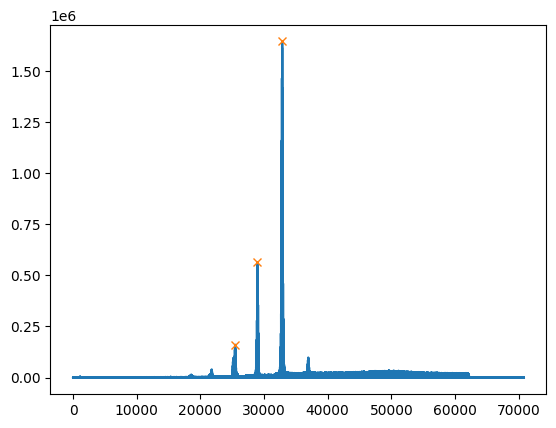

In [58]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

print(len(OzESI_time))
print(list(OzESI_time.items())[:3])
test = pd.DataFrame(list(OzESI_time.items()), columns=['time', 'intensity'])
print(test.head())
#find peaks from test dataframe
peaks, _ = find_peaks(test['intensity'], height=1e5,distance=1000)
print(peaks)
plt.plot(test['intensity'])
plt.plot(peaks, test['intensity'][peaks], "x")
plt.show()

In [5]:
df.tail(5) #Print the pandas dataframe

Parent_Ion Product_Ion        Intensity      Transition Lipid Class  \
30      896.0       597.0   3145901.463318  896.0 -> 597.0   NaN   NaN   
31      898.0       599.0  12535827.163513  898.0 -> 599.0   NaN   NaN   
32      900.0       601.0  14229465.170547  900.0 -> 601.0   NaN   NaN   
33      902.0       603.0  34867382.116547  902.0 -> 603.0   NaN   NaN   
34      904.0       605.0  12858486.610764  904.0 -> 605.0   NaN   NaN   

                                            Sample_ID  
30  TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...  
31  TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...  
32  TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...  
33  TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...  
34  TailoredTAG18-1_O3off_RBDCanola0.0005mgmL_0207...

Load MRM transitions from csv file to pandas dataframe. This list will be used to identify the possible lipids in our sample.

In [ ]:
# #Match Ions in df to mrm_database and append Lipid and Class columns to df
# for index in range(len(df)):
#     for row in range(len(mrm_database)):
#         if mrm_database.loc[row,'Parent_Ion'] == df.loc[index,'Parent_Ion'] and mrm_database.loc[row,'Product_Ion'] == df.loc[index,'Product_Ion']:
#             df.loc[index,'Lipid'] = mrm_database.loc[row,'Lipid']
#             df.loc[index,'Class'] = mrm_database.loc[row,'Class']

# df_matching = df.dropna() #drop rows with NaN values
            

In [ ]:
# create a dictionary to store the matching parent/product ion pairs and their corresponding lipids and classes
ion_dict = {}
for index, row in mrm_database.iterrows():
    ion_dict[(row['Parent_Ion'], row['Product_Ion'])] = (row['Lipid'], row['Class'])

# create empty columns for Lipid and Class
df['Lipid'] = np.nan
df['Class'] = np.nan

# loop through the rows in df and check if the corresponding parent/product ion pair exists in ion_dict
for index, row in df.iterrows():
    if (row['Parent_Ion'], row['Product_Ion']) in ion_dict:
        df.at[index, 'Lipid'] = ion_dict[(row['Parent_Ion'], row['Product_Ion'])][0]
        df.at[index, 'Class'] = ion_dict[(row['Parent_Ion'], row['Product_Ion'])][1]

# drop rows with NaN values
df_matching = df.dropna()


In [ ]:
df_matching.head(None)

In [ ]:
#for loop to check if that file already exists and if it does then add a number to the end of the file name so data is not overwritten
name_of_folder = 'canola'
name_of_file = 'canola'


for i in range(5):
    if not os.path.isfile('data_results/data/data_matching/'+name_of_folder+'/'+name_of_file+'_{}.xlsx'.format(i)):
        df_matching.to_excel('data_results/data/data_matching/'+name_of_folder+'/'+name_of_file+'_{}.xlsx'.format(i), index=False)
        break
    elif not os.path.isfile('data_results/data/data_matching/'+name_of_folder+'/'+name_of_file+'_{}.xlsx'.format(i)):
        df_matching.to_excel('data_results/data/data_matching/'+name_of_folder+'/'+name_of_file+'_{}.xlsx'.format(i), index=False)
        break
    else:
        pass
df_matching.tail(5)

In [ ]:
#import visualization libraries
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
#plot transition versus intensity of df_matching
fig = px.bar(df_matching, x="Transition", y="Intensity", color="Lipid", hover_data=['Lipid','Class'])
fig.show()


#plot lipid class versus intensity of df_matching in a bar chart
fig = px.bar(df_matching, x="Class", y="Intensity", color="Class", hover_data=['Lipid','Class'])
fig.show()
#plot lipid class versus intensity of df_matching in a pie chart
fig = px.pie(df_matching, values='Intensity', names='Class', title='Lipid Class')
fig.show()
#make a plotly heatmap of the intensity of each transition in each sample
fig = go.Figure(data=go.Heatmap(
                     z=df_matching['Intensity'],
                        x=df_matching['Lipid'],
                        y=df_matching['Class'],
                        colorscale='Viridis'))
fig.show()

#plot sample ID versus intensity of df_matching
fig = px.bar(df_matching, x="Sample_ID", y="Intensity", color="Sample_ID", hover_data=['Lipid','Class'])
fig.show()
#plot sample ID versus intensity of df_matching in a pie chart
fig = px.pie(df_matching, values='Intensity', names='Sample_ID', title='Sample ID')
fig.show()